# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#int)
* [Data](#dat)
* [Methodology](#met)
* [Analysis](#res)
* [Discussion](#dis)
* [Conclusion](#con)

## Introduction <a name="int"></a>

**COVID-19 pandemic** has had a dramatic impact on the health and the economy of our societies.

The vaccination is considered as the most effective tool to fight the pandemic and minimise its economical and health impacts.

The **vaccination roll-out** has proved to be complex as it requires an elaborate and complex logistical effort.

The stakeholders want to turn ten pharmacies in vaccination centres in **London**.

To expand vaccination capacity in an efficient way, the stakeholders will to focus on the sectors without hospitals in London.

## Data <a name="dat"></a>

Based on the nature of the problem, the decision will depend on:

* Distribution of hospitals across sectors.

I will define the sectors by regularly-spaced 0.25 Km² sectors centered around Westminster. To do so, I will use `astropy`, `folium` and `foursquare`.

Following this, I will select the sectors without hospitals.

* Distribution of the sectors without hospitals.

I then will use kmeans in `sklearn` the calculate the coordinates of centroids of these sectors to have the most efficient distribution of pharmacies.

* Distribution of pharmacies across the centroids.

I will finally use `foursquare` to obtain the list of closest pharmacies to these centroids.

I first segment the city using a grid with a centre (`u_cen`) in the Palace of Westminster.

In [2]:
#I import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
import numpy as np

I creatre the grid around the centre of London, the Palace of Westminster. I get the geocentric coordinates (i.e. cartesian) with astropy.

Once I have the geocentric coordinates, I transform them into geodetic (i.e. longitude and latitude) so I can use them with `Folium` and `Foursquare`.

In [153]:
#I first retrieve the location of Westminster in geocentric coordinates
u_cen = EarthLocation.of_address('Westminster')

#Variable number of centres
v_noc = 10
#Variable distance between centres
v_dbc = 1000

#List of centres, which I will populate with the longitude, the latitude, the number of hospitals and the geocentric coordinates
l_cen = []

for i in range(int(-v_noc/2),int(v_noc/2)):
    for j in range(int(-v_noc/2),int(v_noc/2)):
        #to_geodetic() transforms geocentric into geodetic coordinates
        u_new = EarthLocation.from_geocentric(u_cen.x + v_dbc * i * u.m, u_cen.y + v_dbc * j * u.m, u_cen.z)
        l_cen.append([float(str(u_new.to_geodetic('WGS84')).split('<Longitude ')[1].split(' deg')[0]), float(str(u_new.to_geodetic('WGS84')).split('<Latitude ')[1].split(' deg')[0]), 0, u_new])

I populate the map of London with the sectors

In [152]:
map_london = folium.Map(location=(51.499167, -0.124722), zoom_start=13)
for i in l_cen:
    folium.Circle([i[1], i[0]], radius=v_dbc/2, color='blue', fill=True).add_to(map_london)    
map_london

### Foursquare

I select the sectors without hospitals using `Foursquare`.

In [176]:
v_cid = 'Y5SGX2GCMQVQF14BCH4OOZ1A03ZV4AMDCKXGWAZXQ3KSWHHY'
v_sec = 'KBCQIPQLU143WWOCUM5X4R2ITIDHKPVAABPH4ITCHNFUXL0J'

I first create the function `f_hos`to retrieve the hospitals per sector as a `list`

In [177]:
import requests

v_cat = '4bf58dd8d48988d196941735' #Category for hospitals

def f_hos(v_lat, v_lon, v_cat, v_cid, v_sec, radius=v_dbc/2, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        v_cid, v_sec, version, v_lat, v_lon, v_cat, radius, limit)
    res= requests.get(url).json()['response']['groups'][0]['items']
    ven = [(item['venue']['id'],
               item['venue']['name'],item['venue']['location']['lat'], item['venue']['location']['lng'],
               item['venue']['location']) for item in res]        
    return ven

I call `f_hos` with the coordinates of every sectot and populate `l_cen` with the number of hospitals per sector

In [178]:
for i in l_cen:
    i[2] = len(f_hos(i[1], i[0], v_cat, v_cid, v_sec))

I produce a map of London with the sectors with hospitals (red) and without (blue)

In [179]:
map_london = folium.Map(location=(51.499167, -0.124722), zoom_start=13)
for i in l_cen:
    v_col = 'blue'
    if i[2] > 0:
        v_col = 'red'
    folium.Circle([i[1], i[0]], radius=v_dbc/2, color=v_col, fill=True).add_to(map_london)    
map_london

### K-means

I use K-means to select the best distribution for the 10 pharmacies that will serve as vaccination centres.

I create a list with the location of the pharmacies in the sectors without hospitals.

To do so, I use the function `f_hos` but with the category code for pharmacies.

In [ ]:
v_cat = '4bf58dd8d48988d10f951735' #Category for pharmacies

l_pha = []

for i in l_cen:
    if i[2] == 0:
        l_pha.append(f_hos(i[1], i[0], v_cat, v_cid, v_sec))

I use k-means to find the 10 best locations (i.e. the centroids) for the vaccine roll-out in the sectors without hospital·

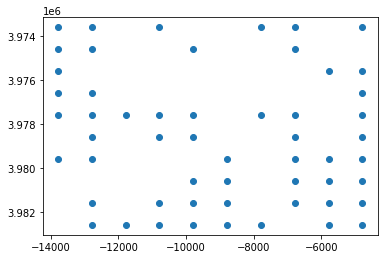

In [197]:
#List of sectors without hospitals

l_sec = [[float(i[3].x.to_string().split(' m')[0]), float(i[3].y.to_string().split(' m')[0])] for i in l_cen if i[2] == 0]

#I create an array of coordinates x and y to plot the distribution of the sectors without hospital

l_x = [i[1] for i in l_sec]
l_y = [i[0] for i in l_sec]

#I plot the sectors without hospital

import matplotlib.pyplot as plt

plt.scatter(x = l_x, y = l_y)
plt.gca().invert_yaxis()

In [198]:
#I use k-means to distribute the ten pharmacies that will serve the sectors without hospitals

from sklearn.cluster import KMeans

v_nop = 10 #Number of pharmacies

kmeans = KMeans(n_clusters= v_nop, random_state=0).fit(l_sec)

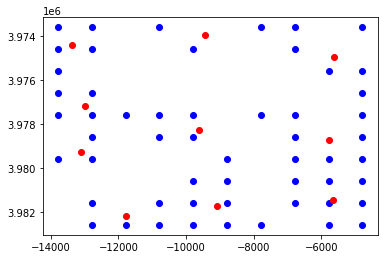

In [201]:
#I populate the list l_clc with the coordinates of the centroids

l_clc = [i for i in kmeans.cluster_centers_]

l_cx = [i[1] for i in l_clc]
l_cy = [i[0] for i in l_clc]

#I plot the sectors without hospitals and the centroids

import matplotlib.pyplot as plt

plt.scatter(x = l_x, y = l_y, color = 'blue')
plt.scatter(x = l_cx, y = l_cy, color = 'red')
plt.gca().invert_yaxis()

I use `foursquare` to find the five closest pharmacies to the centroids, so the stakeholders can examine them and decide which are the best ones to serve the relevant sectors.

In [236]:
v_cat = '4bf58dd8d48988d10f951735'

l_pha = []

v_id = 1 #Centroid id

for i in l_clc:
    #I transform the geocentric coordinates into geodetic
    s_loc = EarthLocation.from_geocentric(i[0] * u.m, i[1], u_cen.z).to_geodetic('WGS84')
    v_lat = float(str(s_loc).split('<Latitude ')[1].split(' deg')[0])
    v_lon = float(str(s_loc).split('<Longitude ')[1].split(' deg')[0])
    l_pha.append([f_hos(v_lat, v_lon, v_cat, v_cid, v_sec, radius = 1000, limit = 5), v_id])
    v_id += 1

## Methodology <a name="met"></a>

In order to make the COVID-19 vaccine roll-out more efficient and equitative, the stakeholders have decided to create ten new vaccine centres in pharmacies within the sectors in London with no hospitals.

I have first divided London in 0.25 Km² sectors and then collected the data of the hospitals within the sector using `astropy` and `foursquare`.

`Astropy` has been instrumental to turn the cartesian coordinates into geodetic and vice versa. The Cartesian coordinates are necessary to create the grid of sectors, while the geodetic are the input for `folium` and `foursquare`.

I have used kmeans in `sklearn` to calculate the optimal centroids for the sectors without hospitals and therefore allow an efficient distribution of pharmacies that will serve as COVID-19 vaccination centres.

I have finally used `foursquare` to obtain the list of closest pharmacies to these centroids so the stakeholders can inspect they characteristics and decide the best ten for the vaccination roll-out programme.

## Results <a name="res"></a>

I create a `dataframe` that I populate with the data to present to the stakeholders.

In [277]:
import pandas as pd

t = pd.DataFrame(columns = ['Sector', 'Pharmacy', 'Address', 'Postal code', 'Distance', 'Latitude', 'Longitude'])

for i in l_pha:
    for j in i[0]:
        try:
            s_add = j[4]['address']
            s_pos = j[4]['postalCode']
        except:
            s_add = ''
            s_pos = ''
        t.loc[len(t)] = [i[1], j[1], s_add, s_pos, j[4]['distance'], j[4]['lat'], j[4]['lng']]

In [278]:
t

,Sector,Pharmacy,Address,Postal code,Distance,Latitude,Longitude
0,1,Superdrug,201-203 Old St,EC1V 9QN,567,51.525572,-0.089128
1,1,Malmin dental,13 Norton Folgate,E1 6bd,602,51.521026,-0.078947
2,1,Apex Pharmacy,199 Old Street,EC1V 9 NP,603,51.525438,-0.089619
3,1,Boots,200 Bishopsgate,EC2M 4NR,927,51.517998,-0.079577
4,1,Boots,11 Octagon Arcade,EC2M 2AB,923,51.518044,-0.082545
5,2,LloydsPharmacy,"62 Wandsworth Road, Vauxall",SW8 2LF,331,51.481173,-0.129096
6,2,Harfleur Pharmacy Stockwell,,,743,51.473199,-0.123698
7,3,Superdrug,80-84 High Rd,NW6 4HS,948,51.538402,-0.194051
8,3,Boots,60-62 Kilburn High Rd,NW6 4HJ,903,51.538025,-0.193313
9,4,Boots,73 Piccadilly,W1J 8HS,556,51.507253,-0.142119


In [284]:
map_london = folium.Map(location=(51.499167, -0.124722), zoom_start=13)
for i in t.index:
    v_col = 'black'
    folium.Circle([t.loc[i, 'Latitude'], t.loc[i, 'Longitude']], radius=25, color=v_col, fill=True).add_to(map_london)    
map_london

## Discussion <a name="res"></a>

COVID-19 pandemic has had a dramatic impact on the health and the economy of our societies.

The vaccination is considered as the most effective tool to fight the pandemic and minimise its economical and health impacts.

The vaccination roll-out has proved to be complex as it requires an elaborate and complex logistical effort.

The distribution of the hospitals in London is not uniform and this poses a risk to the equitable access of its population to vaccination.

The stakeholders have decided to use ten pharmacies in London to complement the vaccination in the hospitals of the city.

To maximise the efficiency of the process, I have selected the sectors in London that do not have a hospital.

Once these sectors have been selected, I used k-means to find the coordinates (centroids) and the closest pharmacies that better serve them.

I present the relevant information on these pharmacies in a table to allow the stakeholders a selection of them.

## Conclusion <a name="conclusion"></a>

This project is an example of the **potential of machine learning** to find an **equitable distribution of health resources** and better serve the public.

The stakeholders will have the final decision on the optimal pharmacy location based on their location and characteristics.